# Latency arbitrage

### Background 
    
This notebook simply compares quality of the exchanges in Malaysia against Binance. The same method can be used on smaller exchanges to identify similar delays.

We looked into Luno and Sinegy mainly in early 2022.

#### References: 

https://websocket-client.readthedocs.io/en/latest/

https://www.luno.com/en/developers/api#tag/Streaming-API

https://github.com/binance/binance-spot-api-docs/blob/master/web-socket-streams.md#trade-streams

In [3]:
import pandas as pd
import numpy as np
from forex_python.converter import CurrencyRates
import matplotlib.pyplot as plt

In [4]:
# get latest MYR 
c = CurrencyRates()
curr = c.get_rate('USD', 'MYR')
curr

4.208975039830059

In [6]:
path1 = './data/luno6.json'
path2 = './data/binance6.json'
path3 = './data/sinegy6.json'
df1 = pd.read_json(path1, lines = True).sort_values('ts').reset_index(drop = True)
df2 = pd.read_json(path2,lines = True).sort_values('ts').reset_index(drop = True)
df3 = pd.read_json(path3,lines = True).sort_values('ts').reset_index(drop = True)
df1 = df1.loc[df1.ts < df2.ts.max()]
df3 = df3.loc[df3.ts < df2.ts.max()]

In [7]:
df1['ts'] = pd.to_datetime(df1['ts'], unit = 'ms')
df2['ts'] = pd.to_datetime(df2['ts'], unit = 'ms')
df3['ts'] = pd.to_datetime(df3['ts'], unit = 'ms')

Sinegy is very illiquid, and this is evident from its sparse orderbook. The delay is longer, but there will be risk of exiting the trade at a good price given the price. However, Sinegy does offer rebates for makers. Given the right condition this could be beneficial.

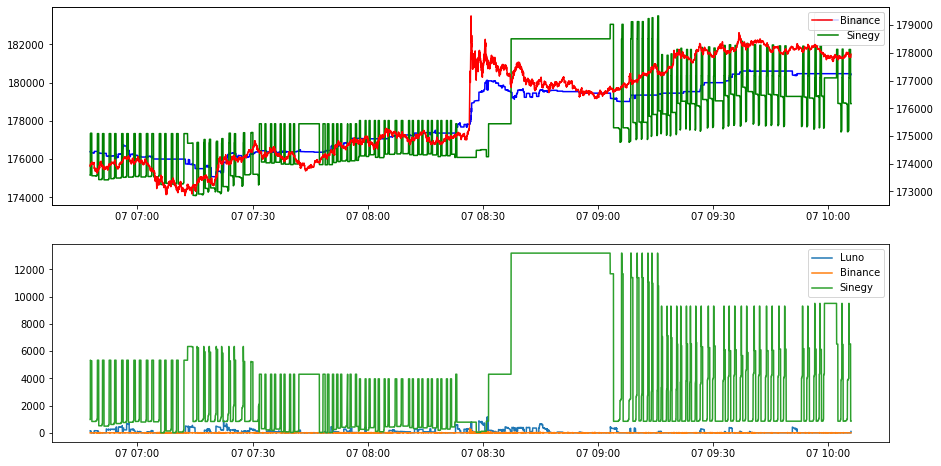

In [11]:
df1 = df1[df1['ts'] > '2022-01-06 23:59:00.000']
df2 = df2[df2['ts'] > '2022-01-06 23:59:00.000']
df3 = df3[df3['ts'] > '2022-01-06 23:59:00.000']
fig, (ax1,ax3) = plt.subplots(2,1, figsize = (15,8))
ax1.plot(df1.ts, df1.mid, label = 'Luno', c = 'b')
ax2 = ax1.twinx()
ax2.plot(df2.ts, df2.mid, label = 'Binance', c = 'r')
ax1.plot(df3.ts, df3.mid, label = 'Sinegy', c ='g')
ax3.plot(df1.ts, df1.spread, label = 'Luno')
ax3.plot(df2.ts, df2.spread, label = 'Binance')
ax3.plot(df3.ts, df3.spread, label = 'Sinegy')
ax1.legend()
ax2.legend()
ax3.legend()

In [8]:
df = df1.merge(df2, how = 'outer', left_on ='ts', right_on ='ts').sort_values('ts').reset_index(drop = True).fillna(method = 'ffill').dropna().reset_index(drop = True)
df['ts_dif'] = df['ts']- df['ts'].shift(1)
df = df[df['ts'] > '2022-01-06 23:59:00.000']
df.head()

,ts,ask_x,bid_x,mid_x,spread_x,ask_y,bid_y,mid_y,spread_y,ts_dif
0,2022-01-07 06:47:39.674,176457.0,176319.0,176388.0,138.0,173909.02475,173908.982815,173909.003782,0.041935,NaT
1,2022-01-07 06:47:40.401,176457.0,176319.0,176388.0,138.0,173909.02475,173908.982815,173909.003782,0.041935,0 days 00:00:00.727000
2,2022-01-07 06:47:41.194,176455.0,176321.0,176388.0,134.0,173909.02475,173908.982815,173909.003782,0.041935,0 days 00:00:00.793000
3,2022-01-07 06:47:41.422,176455.0,176321.0,176388.0,134.0,173909.02475,173908.982815,173909.003782,0.041935,0 days 00:00:00.228000
4,2022-01-07 06:47:41.757,176455.0,176321.0,176388.0,134.0,173909.02475,173908.982815,173909.003782,0.041935,0 days 00:00:00.335000


#### Stationarity of the price ratio

naturally this has to be stationary in short duration, because they are the same price feed, unless USDMYR has a huge intraday drift or price shock. This is also another idea to generate signals.

In [9]:
#swap df1 and df2
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
model = sm.OLS(df['mid_x'],df['mid_y'])
results = model.fit()

residual = df['mid_x'] - results.params[0] * df['mid_y']

print(adfuller(residual,1))

if adfuller(residual, 1)[1] < 0.05:
    print('The series is stationary.')

(-5.435606717382285, 2.850201981030464e-06, 0, 23784, {'1%': -3.430624975021401, '5%': -2.8616615303603106, '10%': -2.56683468710497}, 222398.04160084104)
The series is stationary.


In [10]:
# check if series is normal?
results = sm.stats.lilliefors(df['mid_x']/df['mid_y'])
if results[1] < 0.05:
    print(f"p-value: {results}")
    print("Ratio is normally-distributed.")
else: 
    print("Ratio is not normally-distributed.")

p-value: (0.05219008967774058, 0.0009999999999998899)
Ratio is normally-distributed.


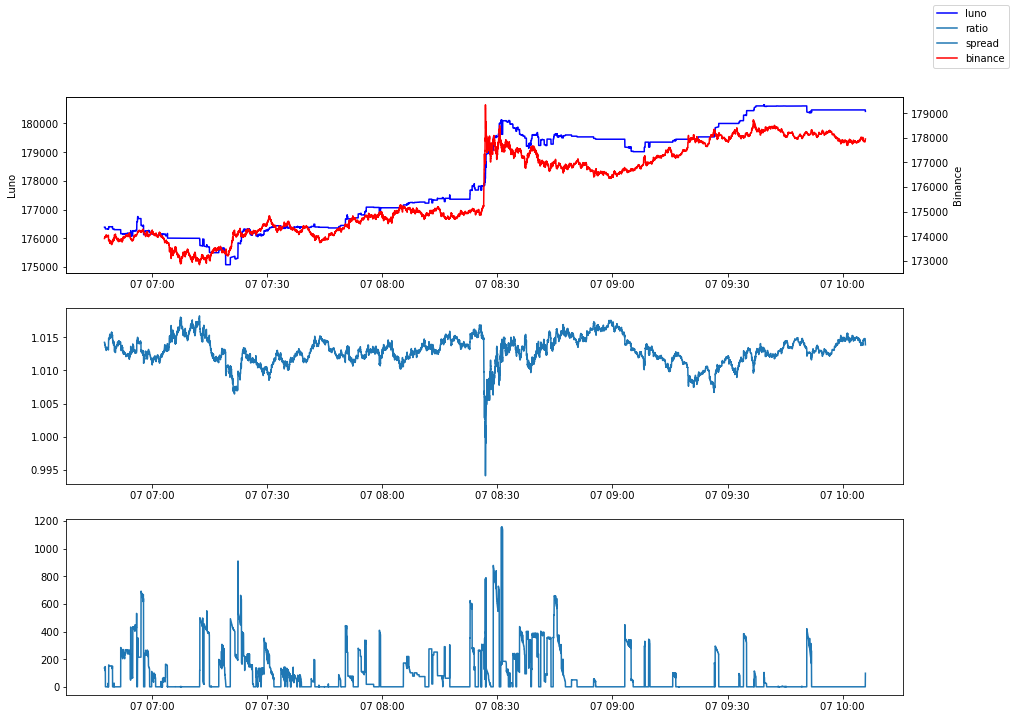

In [11]:
fig, (ax1,ax3, ax4) = plt.subplots(3,1, figsize = (15,11))
ax2 = ax1.twinx()
ax1.plot(df.ts, df.mid_x, label = 'luno',c = 'b')
ax2.plot(df.ts, df.mid_y, label = 'binance', c = 'r')
ax3.plot(df.ts, df.mid_x/df.mid_y, label ='ratio')
ax4.plot(df.ts, df.spread_x, label = 'spread')
ax1.set_ylabel('Luno')
ax2.set_ylabel('Binance')
fig.legend()

#### Cross-correlation
Cross-correlation of signals can be used to identify lead-lag relationship. This can also be used as a parameter to calibrate the lookback window or as another entry condition.

The sample signal here shows a 43s lag. Sometimes you may find higher value quite frequently.

In [12]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

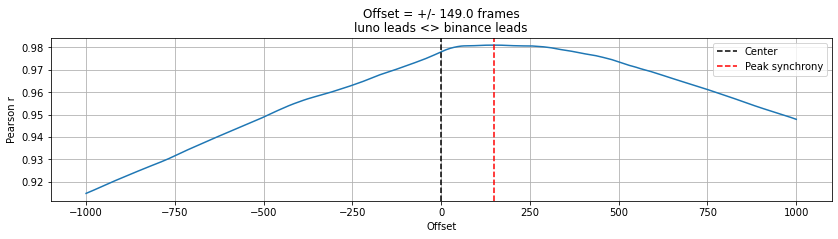

In [13]:
d1 = df["mid_x"]
d2 = df["mid_y"]
cols = ['luno','binance']
seconds = 1000
fps = 1
lag_range = list(range(-int(seconds*fps),int(seconds*fps+1)))
rs = [crosscorr(d1,d2, lag) for lag in lag_range]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(lag_range, rs)
ax.axvline(0,color='k',linestyle='--',label='Center')
ax.axvline(lag_range[np.argmax(rs)],color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = +/- {abs(offset)} frames\n{cols[0]} leads <> {cols[1]} leads', xlabel='Offset',ylabel='Pearson r')
#ax.set_xticks(lag_range)

ax.grid()
# ax.set_xticklabels([-15, -10, -5, 0, 5, 10, 15]);
plt.legend()

In [39]:
print(f"lag on average: {lag_range[np.argmax(rs)] * df.ts_dif.mean()}")

lag on average: 0 days 00:00:43.151705030
